# Initialization and Configuration

In [1]:
master_ip = "192.168.0.100"

deploy_list = [
    "redis-cart",
    "shippingservice",
    "paymentservice",
    "productcatalogservice",
    "emailservice",
    "checkoutservice",
    "recommendationservice",
    "currencyservice",
    "cartservice",
    "adservice",
    "loadgenerator",
    "frontend",
]

# Kubernetes API

In [2]:
from kubernetes import client, config
config.load_kube_config()

api_instance = client.AppsV1Api()

def get_replica_and_ready(deployment_name, deployment_ns="default"):
    api_response = api_instance.read_namespaced_deployment(deployment_name, deployment_ns)
    return api_response.status.replicas, api_response.status.ready_replicas

def set_replica_num(rnum, deployment_name, deployment_ns="default"):
    rnum = int(rnum)
    if rnum < 1:
        rnum = 1
    api_response = api_instance.read_namespaced_deployment(deployment_name, deployment_ns)
    api_response.spec.replicas = rnum
    api_instance.patch_namespaced_deployment_scale(deployment_name, deployment_ns, api_response)

In [3]:
get_replica_and_ready('frontend')

(1, 1)

In [4]:
# set_replica_num(1,'frontend')

# Locust API

In [5]:
import pacs_load_tester as load_tester

locust_base = f"http://{master_ip}:8089/"

In [6]:
# get current status
load_tester.get_current_stats(base=locust_base)

{'current_max_response_time': None,
 'current_min_response_time': None,
 'current_response_time_average': None,
 'current_response_time_percentile_50': None,
 'current_response_time_percentile_95': None,
 'errors': [],
 'fail_ratio': 0.0,
 'state': 'stopped',
 'stats': [{'avg_content_length': 10917.333333333334,
   'avg_response_time': 349.04674941867404,
   'current_fail_per_sec': 0.0,
   'current_rps': 6.0,
   'max_response_time': 585.0,
   'median_response_time': 400.0,
   'method': 'GET',
   'min_response_time': 10.0,
   'name': '/',
   'ninetieth_response_time': 560.0,
   'num_failures': 0,
   'num_requests': 117,
   'safe_name': '/'},
  {'avg_content_length': 7503.339285714285,
   'avg_response_time': 82.25987910632934,
   'current_fail_per_sec': 0.0,
   'current_rps': 3.4,
   'max_response_time': 303.0,
   'median_response_time': 11,
   'method': 'GET',
   'min_response_time': 8.0,
   'name': '/cart',
   'ninetieth_response_time': 290.0,
   'num_failures': 0,
   'num_requests': 

# Running A Sequence

In [7]:
import pandas as pd
from tqdm.auto import tqdm
import time
tqdm.pandas()

loop_timer = load_tester.TimerClass()
total_timer = load_tester.TimerClass()

# user_sequence = [50,100,500,1000,1000,1000,500,100,50]
user_sequence = [50,100]
lt = load_tester.PACSLoadTester(hatch_rate=1000, temp_stat_max_len=5, base=locust_base)
lt.change_count(user_sequence[0])
# wait for changes to take effect
time.sleep(2)
lt.start_capturing()

loop_time_in_secs = load_tester.get_loop_time_in_secs('10s')

loop_timer.tic()
total_timer.tic()

arr_results = []
for i in tqdm(range(len(user_sequence))):
    user_count = user_sequence[i]
    lt.change_count(user_count)
    
    time.sleep(loop_time_in_secs - loop_timer.toc())
    
    loop_timer.tic()
    
    result = lt.get_all_stats()    
    arr_results.append(result)
    
lt.stop_test()

True

In [8]:
results = None
for result in arr_results:
    df_result = pd.DataFrame(data=result)
    
    if results is None:
        results = df_result
    else:
        results = results.append(df_result)

results, filename = lt.prepare_results_from_df(results)

In [9]:
results.head()

,time,current_response_time_percentile_50,current_response_time_percentile_95,current_response_time_average,current_max_response_time,current_min_response_time,fail_ratio,total_rps,user_count,avg_response_time,current_rps,max_response_time,median_response_time,min_response_time,num_failures,num_requests,elapsed,elapsed_min
0,1.610844e+09,300.0,500.0,304,570,10,0.0,0.00,50,391.851575,0.000000,568.0,410.0,104.0,0,52,0.000000,0.000000
1,1.610844e+09,290.0,500.0,263,570,8,0.0,56.50,50,391.851575,26.000000,568.0,410.0,104.0,0,52,2.002223,0.033370
2,1.610844e+09,210.0,500.0,230,570,8,0.0,31.75,50,371.420011,13.000000,568.0,410.0,9.0,0,55,4.004701,0.066745
3,1.610844e+09,210.0,500.0,230,570,8,0.0,31.75,50,371.420011,13.000000,568.0,410.0,9.0,0,55,6.003885,0.100065
4,1.610844e+09,190.0,490.0,197,570,8,0.0,22.00,50,364.950288,7.857143,568.0,410.0,9.0,0,56,8.004728,0.133412


# Plotting The Results

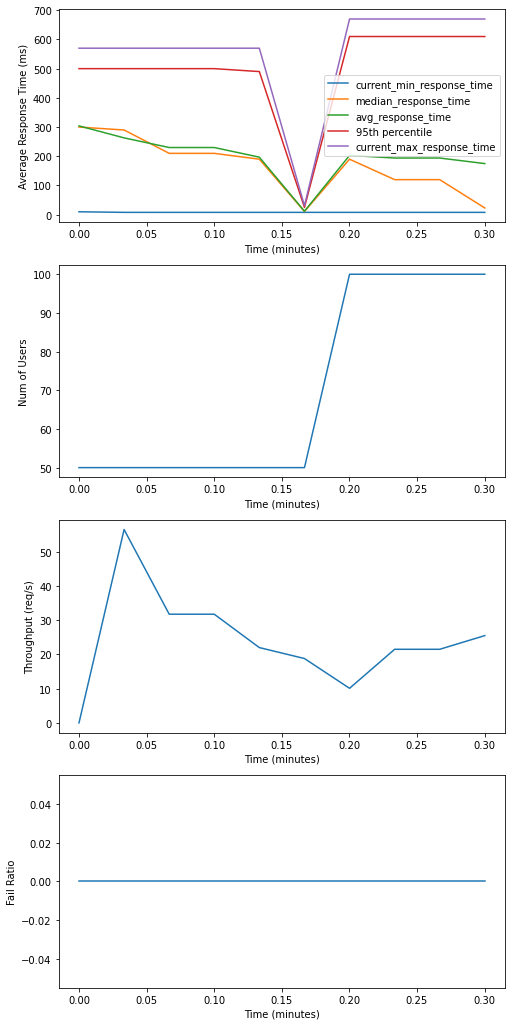

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

res = results

plt.figure(figsize=(8,18))
plt.subplot(411)
plt.plot(res['elapsed_min'], res['current_min_response_time'], label='current_min_response_time')
plt.plot(res['elapsed_min'], res['current_response_time_percentile_50'], label='median_response_time')
plt.plot(res['elapsed_min'], res['current_response_time_average'], label='avg_response_time')
plt.plot(res['elapsed_min'], res['current_response_time_percentile_95'], label='95th percentile')
plt.plot(res['elapsed_min'], res['current_max_response_time'], label='current_max_response_time')

plt.xlabel('Time (minutes)')
plt.ylabel('Average Response Time (ms)')
plt.legend()

plt.subplot(412)
plt.plot(res['elapsed_min'], res['user_count'])
plt.xlabel('Time (minutes)')
plt.ylabel('Num of Users')

plt.subplot(413)
plt.plot(res['elapsed_min'], res['total_rps'])
plt.xlabel('Time (minutes)')
plt.ylabel('Throughput (req/s)')

plt.subplot(414)
plt.plot(res['elapsed_min'], res['fail_ratio'])
plt.xlabel('Time (minutes)')
plt.ylabel('Fail Ratio')

filename = filename.replace('.csv', '')
plt.savefig(filename + '.png', dpi=300)
plt.savefig(filename + '.pdf')
plt.show()


# Pormetheus API

In [11]:
prometheus_base = f"http://{master_ip}:9090"
prometheus_base

'http://192.168.23.88:9090'

In [12]:
from prometheus_api_client import PrometheusConnect
prom = PrometheusConnect(url=prometheus_base, disable_ssl=True)

# Get the list of all the metrics that the Prometheus host scrapes
# (only top 10 is shown)
prom.all_metrics()[:10]

[':kube_pod_info_node_count:',
 ':node_memory_MemAvailable_bytes:sum',
 'ALERTS',
 'ALERTS_FOR_STATE',
 'aggregator_openapi_v2_regeneration_count',
 'aggregator_openapi_v2_regeneration_duration',
 'aggregator_unavailable_apiservice',
 'alertmanager_alerts',
 'alertmanager_alerts_invalid_total',
 'alertmanager_alerts_received_total']

In [13]:
# get pod count
query_pod_count = """count(
        kube_pod_info{namespace="default"}
    ) by (created_by_kind,created_by_name)"""
get_pod_count_query = lambda: prom.custom_query(query=query_pod_count)

count_q_res = get_pod_count_query()
count_q_res[0]

{'metric': {'created_by_kind': 'DaemonSet',
  'created_by_name': 'svclb-frontend-external'},
 'value': [1610844302.641, '2']}

In [14]:
def get_pod_count(deploy_name, query_res):
    filtered_res = [{
        'name': q['metric']['created_by_name'],
        'count': int(q['value'][1]),
    } for q in count_q_res]
    for res in filtered_res:
        if res['name'].startswith(deploy_name):
            return res['count']
    # if not found, return -1
    return -1

get_pod_count('frontend', count_q_res)

1

In [15]:
deploy_pod_counts = {}
for d in deploy_list:
    deploy_pod_counts[d] = get_pod_count(d, count_q_res)
deploy_pod_counts

{'redis-cart': 1,
 'shippingservice': 1,
 'paymentservice': 1,
 'productcatalogservice': 1,
 'emailservice': 1,
 'checkoutservice': 1,
 'recommendationservice': 1,
 'currencyservice': 1,
 'cartservice': 1,
 'adservice': 1,
 'loadgenerator': 1,
 'frontend': 1}

In [16]:
# get workload cpu
query_workload_cpu = """
sum(
  rate(container_cpu_usage_seconds_total{cluster="", namespace="default"}[2m])
* on(namespace,pod)
  group_left(workload, workload_type) namespace_workload_pod:kube_pod_owner:relabel{cluster="", namespace="default", workload_type="deployment"}
) by (workload, workload_type)
"""
get_workload_cpu_query = lambda: prom.custom_query(query=query_workload_cpu)

wl_cpu_res = get_workload_cpu_query()
wl_cpu_res[0]

{'metric': {'workload': 'emailservice', 'workload_type': 'deployment'},
 'value': [1610844304.573, '0.005017956942778258']}

In [17]:
# filter results (unit is millicores)
filtered_cpu_query = { q['metric']['workload']: float(q['value'][1])*1000 for q in wl_cpu_res }
filtered_cpu_query

{'emailservice': 5.017956942778258,
 'shippingservice': 4.109814280540783,
 'cartservice': 6.297491712560369,
 'paymentservice': 2.5204650182161386,
 'frontend': 9.51284468287259,
 'productcatalogservice': 2.250330067563266,
 'checkoutservice': 4.575033024047848,
 'adservice': 11.257179402287719,
 'currencyservice': 8.839029328085152,
 'redis-cart': 0.8577635425493534,
 'loadgenerator': 0.7554945029643577,
 'recommendationservice': 9.66668666129519}